# Метод обратного распространения ошибки

Обучение нелинейного нейрона.  Проблема обучения нелинейного нейрона в скрытом слое состоит в том, что для адаптации параметров нейрона нужно знать ошибку на выходе нейрона.

Последовательность перехода сигнала определяется конструкцией нейрона и характеристикой, которую обеспечивает активационная функция.  



In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

Нейрон для анализа - логистического типа. Определим основные функции для обработки: 

- to_one_hot(Y) : преобразует значение в вектор по правилу one-hot-encoding ( пример при 10 классах, значение Y=4 переведем в вектор <0, 0, 0, 0, 1, 0, 0, 0, 0, 0 >),

- from_one_hot(Y) : переводит вектор one-hot-encoding в значение чскаоярного типа (вектор Y <0, 0, 0, 0, 1, 0, 0, 0, 0, 0 > переводится в значение 4)

- sum_neuron(x=None, w=None) : вернет свертку векторов x, w - на выходе скалярное значение - внутреннее состояние нейрона,

-  sigmoid_complex_neuron(x = None, w = None, bias=0, lymbd = 1) : логистический нейрон с входным набором значений х  и настраиваемыми параметрами w.

- sigmoid_deriv(g) : производная логистического нейрона, 

- normalize(X, axis=-1, order=2) : нормализация признаков - делаем входы удобными для нейрона

In [0]:


# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    #print(n_col)
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная

def sum_neuron(x=None, w=None):
    return np.dot(w.T,x.T )

def sigmoid_complex_neuron(x = None, w = None, bias=0, lymbd = 1):
    #print('X: ',x)
    #print('W: ',w)
    #print('bias: ',bias)
    s = sum_neuron(x=x, w=w).T
    #print(s.shape)
    #print('суммарный уровень входов нейрона на их веса: ',s)
    y = 1 / (1 + np.exp(-s/lymbd))
    return y

def sigmoid_deriv(g):
    return g*(1 - g)

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)




Откроем данные для обучения . Это баща для классификации - "Ирисы Фишера". 4 признака, 3 класса (сорта ирисов обозначены 0, 1, 2 - в оригинале "Setosa", "Virginica", "Versicolor")

In [0]:
# Подготовка тренировочных данных
# 
iris_ = load_iris()

#данные для входной части модели
iris_data=iris_.data
# данные для выходной части модели
iris_target=iris_.target


Список классов

In [0]:
iris_.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Список признаков модели.

In [0]:
feature=iris_.feature_names
feature

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [0]:
# формирование входных данных
columns = feature
x = pd.DataFrame(data=iris_data, columns=columns)

#сразу сделаем нормализацию

x = normalize(x.as_matrix())

# формирование выходных данных(результатов)
columns = ['Сорт']
y = pd.DataFrame(iris_target, columns=columns)
y = y.as_matrix()
y = y.flatten()
# сразу делаем перевод в векторную форму выходного свойства
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

# покажем размер данных для обучениия
print(X_train.shape)


(100, 4)


Пример выходного свойства (это был ирис сорта 0 - "setosa")

In [0]:
y_train[0]

array([0., 1., 0.])

In [0]:
import seaborn as sns



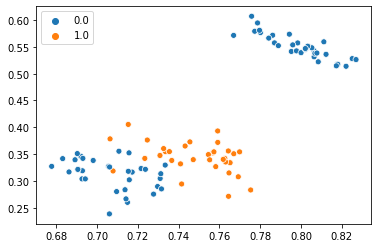

In [0]:
sns.scatterplot(x=X_train[:,0],y=X_train[:,1], hue = y_train[:,1])
plt.show()

## Метод обратного распространения ошибки

ПОпробуем обучить нелинейную нейронную сеть в конфигурации 4-входа, 1 нейрон скрытого слоя, 3 нейрона на выходе.

### Обученние нейрона скрытого слоя сети

Сделаем модель на основе 2-х слойной сети с одним скрытым нейроном. Объекты для обучения "Ирисы Фишера". 

1. Начнем с инициализации весов (3 выхода - 3 нейрона на выходе, один нейрон в скрытом слое)

In [0]:
neuron = 1
# 
# присваевание случайных весов
w0 = 2*np.random.random((4, neuron)) - 1 # для входного слоя   - 4 входа, neuron выхода
w1 = 2*np.random.random((neuron, 3)) - 1 # для внутреннего слоя - neuron входов, 3 выхода

In [0]:
w0

array([[ 0.33994829],
       [-0.85913567],
       [ 0.3128439 ],
       [-0.05055447]])

In [0]:
w1

array([[ 0.25381593, -0.36926483,  0.1272607 ]])

2. Прямой проход - пропустим сигнал ( 0-й пример из выборки) через нейрон скрытого слоя и 3 нейрона на выходе

In [0]:
layer0 = X_train[0,:]
layer1 = sigmoid_complex_neuron(x= layer0, w=w0)
layer2 = sigmoid_complex_neuron(x=layer1, w=w1)
print('выход скрытого слоя',layer1)
print('выход второго-выходного слоя',layer2)

выход скрытого слоя [0.53078169]
выход второго-выходного слоя [0.53362936 0.45115651 0.51688049]


3. Ошибка на выходе

In [0]:
layer2_error = y_train[0] - layer2
print('ошибка сети по выходам',layer2_error) 

ошибка сети по выходам [-0.53362936  0.54884349 -0.51688049]


4. Вычислим производные по нейронам для объекта 0 из выборки

In [0]:
dlayer2 = sigmoid_deriv(layer2)
dlayer1 = sigmoid_deriv(layer1)
print('производнаяя для нейронов выходного слоя: ',dlayer2)
print('производнаяя для нейронов выходного слоя: ', dlayer1)

производнаяя для нейронов выходного слоя:  [0.24886907 0.24761431 0.24971505]
производнаяя для нейронов выходного слоя:  [0.24905249]


5. Понесли ошибку из выходного слоя в первый

Сначала найдем коэффициент переноса

In [0]:
layer2_delta = layer2_error*dlayer2 
layer2_delta

array([-0.13280384,  0.1359015 , -0.12907284])

Посчитаем ошибку в слое 1 (скрыты слой)

In [0]:
layer1_error = np.sum(layer2_delta.reshape((3, 1)) * w1.T, axis=0)

layer1_error

array([-0.10031728])

6. Определим коэфициент переноса через слой 1

In [0]:
layer1_delta = layer1_error*dlayer1 
layer1_delta

array([-0.02498427])

7. Почитаем корректировку параметров нейрона

In [0]:
n = 0.1

dw1 = layer2_delta.reshape((3, 1)) * layer1.T * n
dw0 =layer1_delta.reshape((neuron, 1)) * layer0.T * n

print(dw0)
print(dw1)

[[-0.00186668 -0.00084849 -0.00135758 -0.00044122]]
[[-0.00704898]
 [ 0.0072134 ]
 [-0.00685095]]


8. Сделаем корректировку

In [0]:
w1 += dw1.T
w0 += dw0.T
print(w0)
print(w1)

[[ 0.33808161]
 [-0.85998416]
 [ 0.31148631]
 [-0.05099568]]
[[ 0.24676695 -0.36205142  0.12040975]]


Обучение нелинейной сети можно описать следующим образом:

1. Прямой проход - пропустим примеры для обучения через слои сети
2. Вычислим ошибку на выходе
3. Проведем обратное распраостранение ошибки:

    - вычислим производные,
    
    - определим коэффициент переноса ошибки через слой
    
    - вычислим ошибку на скрытом слое
 
4. Вычисление поправки к параметрам нейронов по всем слоям
5. Вносим поправку в параметры нейронов
6. Проверяем ошибку на выходе и принимаем решение о продолжении обучения (Если ошибка на выходе достаточно маленькая, то закончить обучение. Если ошибка не соответствует уровню, который определен условие, то продолжае обучение - перейдем к п.1  )

In [0]:
###  Обученние нейронной сети

#  число нейронов скрытого слоя
neuron = 10

# присваевание случайных весов
w0 = 2*np.random.random((4, neuron)) - 1 # для входного слоя   - 4 входа, neuron выхода
w1 = 2*np.random.random((neuron, 3)) - 1 # для внутреннего слоя - neuron входов, 3 выхода

# скорость обучения (learning rate)
n = 0.01

# массив для хранения ошибок
errors = []

# обучение
batch_size = 10
# i счетчик эпох
for i in range(20):
    # j номер объекта для обработки
    for jk in range(X_train.shape[0]-80):
        
        ######  ПРЯМОЙ ПРОХОД
        j = np.random.randint(0,X_train.shape[0],(batch_size))
        # вход
        layer0 = X_train[j,:]
        # слой 1
        layer1 = sigmoid_complex_neuron(x= layer0, w=w0)
        # слой 2
        layer2 = sigmoid_complex_neuron(x=layer1, w=w1)
        #print(layer2, layer1)
        
        ###### ОБРАТНЫЙ ПРОХОД
        # вычисление ошибки на выходе
        layer2_error = y_train[j] - layer2
        #print(layer2_error)
        # запишем ошибку
        errors.append(np.mean(np.abs(layer2_error)).copy())
        
        # вычисляем производную по слоям - на выходе будет вектор для каждого примера 
        # слой 1 - вектор размера (число примеров, 5)
        dlayer2 = sigmoid_deriv(layer2)
        # слой 2 - вектор размера (число примеров, 3)
        dlayer1 = sigmoid_deriv(layer1)
        print('производнаяя для нейронов выходного слоя: ',dlayer2)
        print('производнаяя для нейронов скрытого слоя: ', dlayer1)
        
        # посчитаем коэффициент переноса ошибки
        layer2_delta = layer2_error*dlayer2 
        print('delta 2: ', layer2_delta)
        # вычислим ошибку на выходе слоя 1
        layer1_error = np.sum(layer2_delta.reshape((3, batch_size)) * w1.T, axis=0)
        # посчитаем коэффициент переноса ошибки черех слой 1         
        layer1_delta = layer1_error*dlayer1 
        print(layer2_delta.shape)
        print(layer2.shape)
        # вычислить поправку 
        dw1 = np.dot(layer2_delta.reshape((3, batch_size)), layer1) * n
        dw0 =np.dot(layer1_delta.reshape((neuron, batch_size)),layer0 )* n
        print('dw1 = ',dw1)
        print('dw0 = ',dw0)
        # делаем поправку
        w1 += dw1.T
        w0 += dw0.T
        
        

Streaming output truncated to the last 5000 lines.
dw0 =  [[2.26377056e-04 9.70871280e-05 2.08209426e-04 5.59468171e-05]
 [2.26955195e-04 9.73399102e-05 2.08643981e-04 5.60745357e-05]
 [2.23885216e-04 9.60210259e-05 2.06079297e-04 5.51981117e-05]
 [2.22959730e-04 9.56249216e-05 2.05379992e-04 5.50184643e-05]
 [2.24353235e-04 9.62219949e-05 2.06673109e-04 5.55670103e-05]
 [2.25809059e-04 9.68191660e-05 2.07777171e-04 5.57031444e-05]
 [2.28031459e-04 9.78053955e-05 2.09596732e-04 5.64458699e-05]
 [2.45232641e-04 1.05346783e-04 2.24775249e-04 6.20906864e-05]
 [2.23994509e-04 9.60205308e-05 2.06618510e-04 5.54901776e-05]
 [2.26978229e-04 9.73457843e-05 2.08709471e-04 5.61122559e-05]]
производнаяя для нейронов выходного слоя:  [[0.20199153 0.23409127 0.22821849]
 [0.20549693 0.24032794 0.22906362]
 [0.20543536 0.24036463 0.22907577]
 [0.19909512 0.23037646 0.22929861]
 [0.19979153 0.23101389 0.22900511]
 [0.20044835 0.23309929 0.22855848]
 [0.20594878 0.23998266 0.22868711]
 [0.20090076 0.2

###  точность в зависимости от обучения

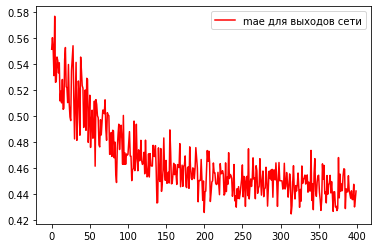

In [0]:
# отобразим результаты

plt.plot(errors,'r',label='mae для выходов сети')
plt.legend()
plt.show()

In [0]:
def net_MLP(epoch = 5000, neuron = 5 ,lyambd = 0.1, X_train = None, X_test = None, y_train = None, y_test = None, batch_size = 10, n = 0.01):
    # скорость обучения (learning rate)
 
    
    # Инициализация параметров
    w0 = 2*np.random.random((4, neuron)) - 1 # для входного слоя   - 4 входа, neuron выхода
    w1 = 2*np.random.random((neuron, 3)) - 1 # для внутреннего слоя - neuron входов, 3 выхода

    # массив для ошибок
    errors = []
    errors_test=[]
    df=[]

    
    
    # массив для ошибок, чтобы потом построить график
    layer0 = X_train
    layer1 = sigmoid_complex_neuron(x= layer0, w=w0)
    layer2 = sigmoid_complex_neuron(x=layer1, w=w1)
    layer2_error = (y_train - layer2)

    # Сделаем оценку
    Q = np.mean(np.abs(layer2_error)).copy()
    
    # процесс обучения
    for i in range(epoch):
        #print(i)
        # ПРЯМОЙ ПРОХОД
    
        # создадим список примеров для обучения
        j = np.random.randint(0,X_train.shape[0],(batch_size))
        layer0 = X_train[j,:]
        layer1 = sigmoid_complex_neuron(x= layer0, w=w0)
        layer2 = sigmoid_complex_neuron(x=layer1, w=w1)
        #print(layer2.shape, layer1.shape)
        
        # Ошибка на выходе
        layer2_error = y_train[j] - layer2
        #print(layer2_error.shape)
        
        
        Q=Q*(1-lyambd)+lyambd*np.mean(np.abs(layer2_error))
        errors.append(Q.copy())
    
        # Производная
        dlayer2 = sigmoid_deriv(layer2)
        dlayer1 = sigmoid_deriv(layer1)
        #print('производнаяя для нейронов выходного слоя: ',dlayer2.shape)
        #print('производнаяя для нейронов скрытого слоя: ', dlayer1)
        
        # поправки дляя обратного прохода    
        layer2_delta = layer2_error*dlayer2 
    
    
        layer1_error = np.dot(layer2_delta , w1.T)
                
        layer1_delta = layer1_error*dlayer1 
        
        #  вычисляем поправку для параметров нейронов            
        dw1 = np.dot(layer2_delta.reshape((layer2_delta.shape[1], layer2_delta.shape[0])),layer1) * n
        dw0 = np.dot(layer1_delta.reshape((neuron, layer1_delta.shape[0])),layer0) * n
       
        w1 += dw1.T
        w0 += dw0.T
        
        error = np.mean(np.abs(layer2_error))
        accuracy = (1 - error.copy()) * 100
    
        # оценка сети на тестах
        layer0_test = X_test
        layer1_test = sigmoid_complex_neuron(x= layer0_test, w=w0)
        layer2_test = sigmoid_complex_neuron(x=layer1_test, w=w1)
        
        
        layer2_error_test = y_test - layer2_test
    
        error = np.mean(np.abs(layer2_error_test))
        errors_test.append(error.copy())
    
        accuracy_test = (1 - error.copy()) * 100
        
    return accuracy, accuracy_test, w0, w1, errors_test, errors
    


In [0]:
accuracy, accuracy_test, w0, w1, errors_test, errors = net_MLP(epoch=15000, neuron = 5 ,lyambd = 0.02, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, batch_size = 1, n = 0.1)

Точность нейронной сети 67.98%
Точность нейронной сети test 76.88%


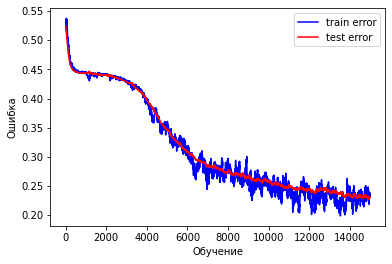

In [0]:
plt.plot(errors,'b', label='train error')
plt.plot(errors_test,'r', label='test error')
plt.legend()
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
# plt.show() # расскоментируйте, чтобы посмотреть 

        
print("Точность нейронной сети " + str(round(accuracy,2)) + "%")
print("Точность нейронной сети test " + str(round(accuracy_test,2)) + "%")

### Переобучение - недообучение

Точность нейронной сети 55.57%
Точность нейронной сети test 55.31%


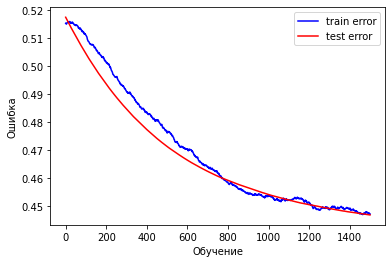

In [0]:
accuracy, accuracy_test, w0, w1, errors_test, errors = net_MLP(epoch=1500, neuron = 5 ,lyambd = 0.01, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, batch_size = 20, n = 0.001)

plt.plot(errors,'b', label='train error')
plt.plot(errors_test,'r', label='test error')
plt.legend()
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
# plt.show() # расскоментируйте, чтобы посмотреть 

        
print("Точность нейронной сети " + str(round(accuracy,2)) + "%")
print("Точность нейронной сети test " + str(round(accuracy_test,2)) + "%")


Точность нейронной сети 58.26%
Точность нейронной сети test 59.34%


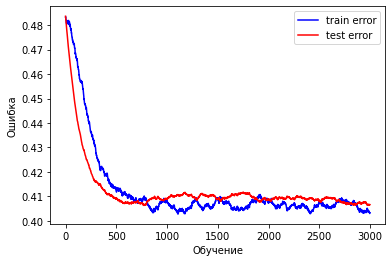

In [0]:
accuracy, accuracy_test, w0, w1, errors_test, errors = net_MLP(epoch=3000, neuron = 50 ,lyambd = 0.01, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, batch_size = 20, n = 0.001)

plt.plot(errors,'b', label='train error')
plt.plot(errors_test,'r', label='test error')
plt.legend()
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
# plt.show() # расскоментируйте, чтобы посмотреть 

        
print("Точность нейронной сети " + str(round(accuracy,2)) + "%")
print("Точность нейронной сети test " + str(round(accuracy_test,2)) + "%")

###  Затухание градиента

Посмотрим как затухает градиент по слоям. Построим сеть из 5 слоев. Проведем по этой сети объект  X_train[0,:].

In [0]:
neuron = 1
# 
# присваевание случайных весов
w0 = 2*np.random.random((4, neuron)) - 1 # для входного слоя   - 4 входа, neuron выхода
w1 = 2*np.random.random((neuron, neuron)) - 1 # для внутреннего слоя - neuron входов, 3 выхода
w2 = 2*np.random.random((neuron, neuron)) - 1 # для внутреннего слоя - neuron входов, 3 выхода
w3 = 2*np.random.random((neuron, neuron)) - 1 # для внутреннего слоя - neuron входов, 3 выхода
w4 = 2*np.random.random((neuron, neuron)) - 1 # для внутреннего слоя - neuron входов, 3 выхода
w5 = 2*np.random.random((neuron, 3)) - 1 # для внутреннего слоя - neuron входов, 3 выхода


ПРЯМОЕ РАСПРОСТРАНЕНИЕ

In [0]:
layer0 = X_train[0,:]
layer1 = sigmoid_complex_neuron(x= layer0, w=w0)
layer2 = sigmoid_complex_neuron(x=layer1, w=w1)
layer3 = sigmoid_complex_neuron(x=layer2, w=w1)
layer4 = sigmoid_complex_neuron(x=layer3, w=w1)
layer5 = sigmoid_complex_neuron(x=layer4, w=w1)

In [0]:
layer5

array([0.44387981])

ОБРАТНОЕ РАСПРОСТРАНЕНИЕ

In [0]:

dlayer5 = sigmoid_deriv(layer5)
dlayer4 = sigmoid_deriv(layer4)
dlayer3 = sigmoid_deriv(layer3)
dlayer2 = sigmoid_deriv(layer2)
dlayer1 = sigmoid_deriv(layer1)

In [0]:
dlayer1

array([0.24973635])

Покажем как изменялся сигнал в сети

In [0]:
e5 = y_train[0] - layer5

de4 = e5 * dlayer5 * layer4

de3 = de4 * dlayer4 * layer3

de2 = de3 * dlayer3 * layer2

de1 = de2 * dlayer2 * layer1

In [0]:
print(e5[0])
print(de4[0])
print(de3[0])
print(de2[0])
print(de1[0])

-0.44387980913173986
-0.04861921279663539
-0.00534033366429751
-0.0005734764107112513
-7.275413963375523e-05


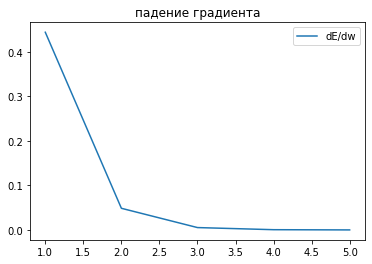

In [0]:
plt.plot([1,2,3,4,5],np.abs(np.array([e5[0],de4[0],de3[0],de2[0],de1[0]])),label = 'dE/dw')
plt.title('падение градиента')
plt.legend()
plt.show()

In [0]:
# Requires the latest pip
!pip install --upgrade pip

# Current stable release for CPU and GPU
!pip install tensorflow

# Or try the preview build (unstable)
!pip install tf-nightly

     |████████████████████████████████| 1.4MB 2.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 533.2 MB 23 kB/s 
     |████████████████████████████████| 454 kB 82.6 MB/s 
     |████████████████████████████████| 2.8 MB 46.1 MB/s 
     |████████████████████████████████| 2.9 MB 53.3 MB/s 
     |████████████████████████████████| 775 kB 23.1 MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Attempting uninstall: gast
    Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Attempting uninstall: h5p

In [0]:
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# загрузка тренировочных и тестовых данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# конвертация чисел из uint8 в float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# нормализация данных [0, 1]
x_train /= 255 
x_test /= 255 

# трансформация лейблов в one-hot encoding
y_train = to_categorical(y_train, 10) 
y_test = to_categorical(y_test, 10) 

# изменение размерности массива в 4D массив
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

11493376/11490434 [==============================] - 0s 0us/step


## Замена слоев

Предобученную сеть можно изменить. Начнем с построения сети для MNIST.

In [0]:
from tensorflow.keras.models import Model 
# инициализация  модели
input1= tensorflow.keras.layers.Input(shape=(28,28,1))
# первый сверточный слой
x1 = tensorflow.keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh',  padding="same")(input1)

# второй пуллинговый слой
x2 = tensorflow.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(x1)

# третий сверточный слой
x3 = tensorflow.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid')(x2)

# четвертый пуллинговый слой
x4 = tensorflow.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x3)

# пятый  слой
x5 = tensorflow.keras.layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid')(x4)

# сглаживание CNN выхода чтобы можно было его присоединить к полносвязногому слою
x6 = tensorflow.keras.layers.Flatten()(x5)

# шестой полносвязный слой
x7 = tensorflow.keras.layers.Dense(84, activation='tanh')(x6)

# выходной слой с функцией активации softmax
out_x = tensorflow.keras.layers.Dense(10, activation='softmax')(x7)

model1 = Model(inputs = input1, outputs = out_x)
model3 = Model(inputs = input1, outputs = x3)
model5 = Model(inputs = input1, outputs = x5)
# компилияция модели
model1.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])



In [0]:
hist = model1.fit(x=x_train,y=y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

test_score = model1.evaluate(x_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 45us/sample - loss: 0.6560 - acc: 0.8344 - val_loss: 0.3286 - val_acc: 0.9126
Epoch 2/10
60000/60000 [==============================] - 3s 44us/sample - loss: 0.3043 - acc: 0.9135 - val_loss: 0.2531 - val_acc: 0.9294
Epoch 3/10
60000/60000 [==============================] - 3s 43us/sample - loss: 0.2471 - acc: 0.9293 - val_loss: 0.2135 - val_acc: 0.9399
Epoch 4/10
60000/60000 [==============================] - 3s 43us/sample - loss: 0.2125 - acc: 0.9391 - val_loss: 0.1863 - val_acc: 0.9474
Epoch 5/10
60000/60000 [==============================] - 3s 43us/sample - loss: 0.1876 - acc: 0.9466 - val_loss: 0.1679 - val_acc: 0.9519
Epoch 6/10
60000/60000 [==============================] - 3s 43us/sample - loss: 0.1692 - acc: 0.9515 - val_loss: 0.1522 - val_acc: 0.9562
Epoch 7/10
60000/60000 [==============================] - 3s 43us/sample - loss: 0.1540 - acc: 0.9559 - val_loss: 0.

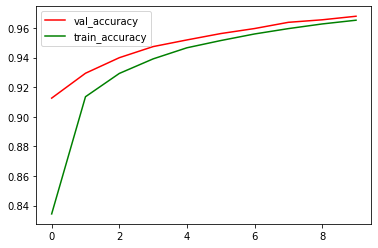

In [0]:
plt.plot(hist.history['val_acc'],'r',label='val_accuracy')
plt.plot(hist.history['acc'],'g',label='train_accuracy')
plt.legend()
plt.show()

In [0]:
model1.save_weights('my_model1.h5')

Создадим модель снова (вплоть до создания объекта и компиляции)

In [0]:
model1.load_weights('my_model1.h5')

In [0]:
model1.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_8 (Average (None, 27, 27, 6)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 23, 23, 16)        2416      
_________________________________________________________________
average_pooling2d_9 (Average (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 120)         48120     
_________________________________________________________________
flatten_4 (Flatten)          (None, 5880)              0  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


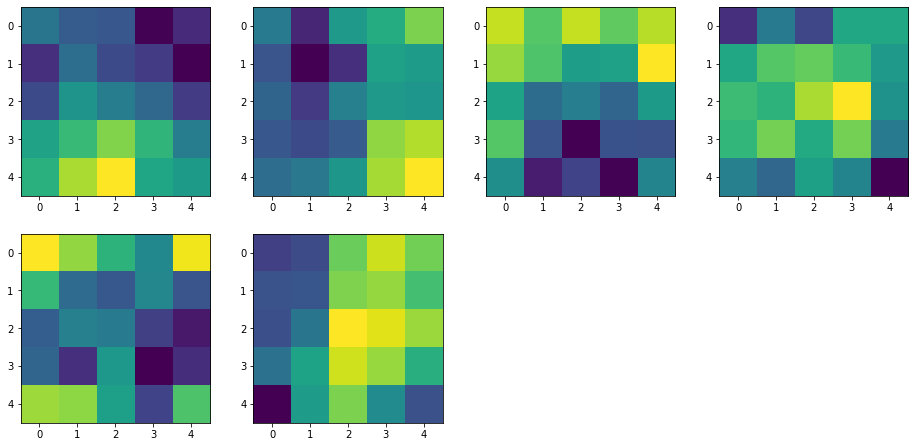

In [0]:
wg = model5.get_layer(index = 1)
w_ = wg.get_weights()

plt.figure(figsize=(16,16))
for i in range(2):
  for j in range(4):
    plt.subplot(4,4,i*2+j+1)
    plt.imshow(w_[0][:,:,0,i*2+j])
plt.show()

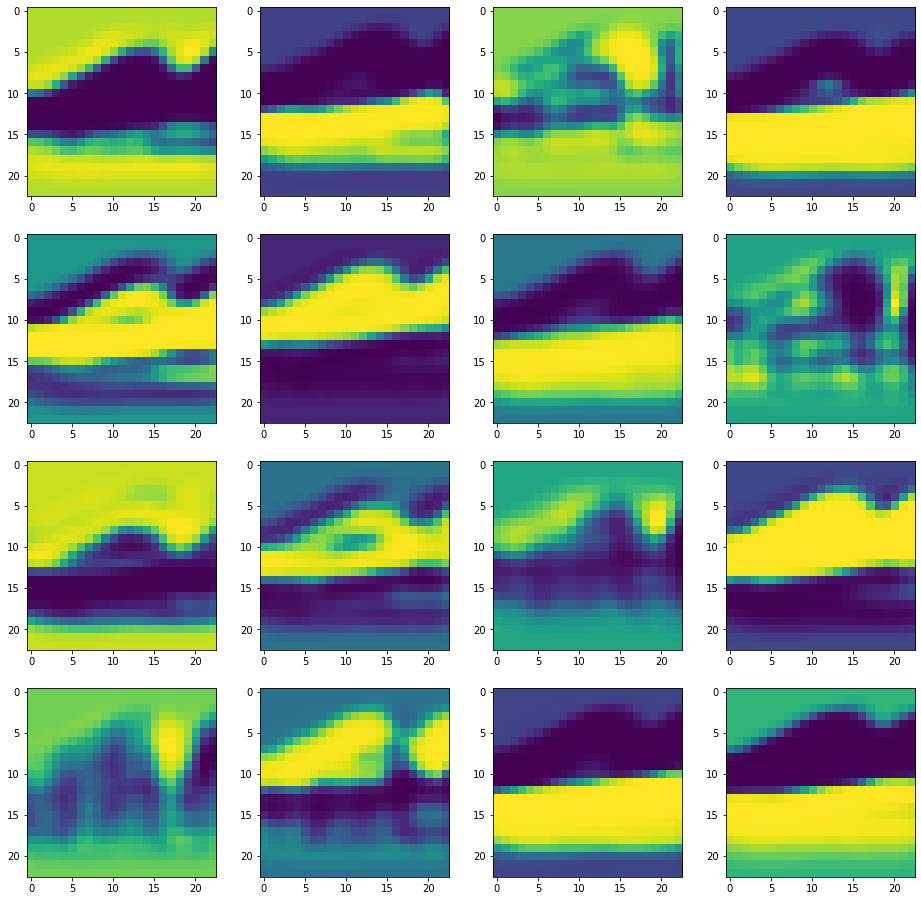

In [0]:
b1 = model3.predict(x_test[:10])

plt.figure(figsize=(16,16))
for i in range(4):
  for j in range(4):
    plt.subplot(4,4,i*4+j+1)
    plt.imshow(b1[9][:,:,i*4+j])
plt.show()

In [0]:
l1 = model1.layers[-1]
l2 = model1.layers[-2]

In [0]:
model1.layers[1].trainable = False
model1.layers[3].trainable = False


In [0]:
from tensorflow.keras.datasets import fashion_mnist


# загрузка тренировочных и тестовых данных
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# конвертация чисел из uint8 в float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# нормализация данных [0, 1]
x_train /= 255 
x_test /= 255 

# трансформация лейблов в one-hot encoding
y_train = to_categorical(y_train, 10) 
y_test = to_categorical(y_test, 10) 

# изменение размерности массива в 4D массив
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
hist = model1.fit(x=x_train,y=y_train, epochs=30, batch_size=128, validation_data=(x_test, y_test), verbose=1)

test_score = model1.evaluate(x_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 3s 43us/sample - loss: 0.3095 - acc: 0.8894 - val_loss: 0.3536 - val_acc: 0.8733
Epoch 2/30
60000/60000 [==============================] - 3s 43us/sample - loss: 0.3055 - acc: 0.8906 - val_loss: 0.3722 - val_acc: 0.8658
Epoch 3/30
60000/60000 [==============================] - 3s 43us/sample - loss: 0.3018 - acc: 0.8914 - val_loss: 0.3558 - val_acc: 0.8699
Epoch 4/30
60000/60000 [==============================] - 3s 43us/sample - loss: 0.2979 - acc: 0.8937 - val_loss: 0.3426 - val_acc: 0.8760
Epoch 5/30
60000/60000 [==============================] - 3s 43us/sample - loss: 0.2940 - acc: 0.8940 - val_loss: 0.3406 - val_acc: 0.8777
Epoch 6/30
60000/60000 [==============================] - 3s 42us/sample - loss: 0.2900 - acc: 0.8951 - val_loss: 0.3372 - val_acc: 0.8806
Epoch 7/30
60000/60000 [==============================] - 3s 43us/sample - loss: 0.2869 - acc: 0.8974 - val_loss: 0.

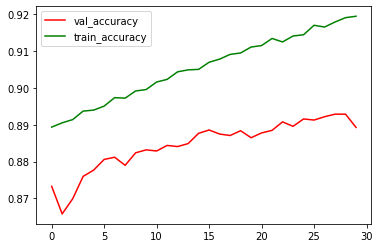

In [0]:
plt.plot(hist.history['val_acc'],'r',label='val_accuracy')
plt.plot(hist.history['acc'],'g',label='train_accuracy')
plt.legend()
plt.show()

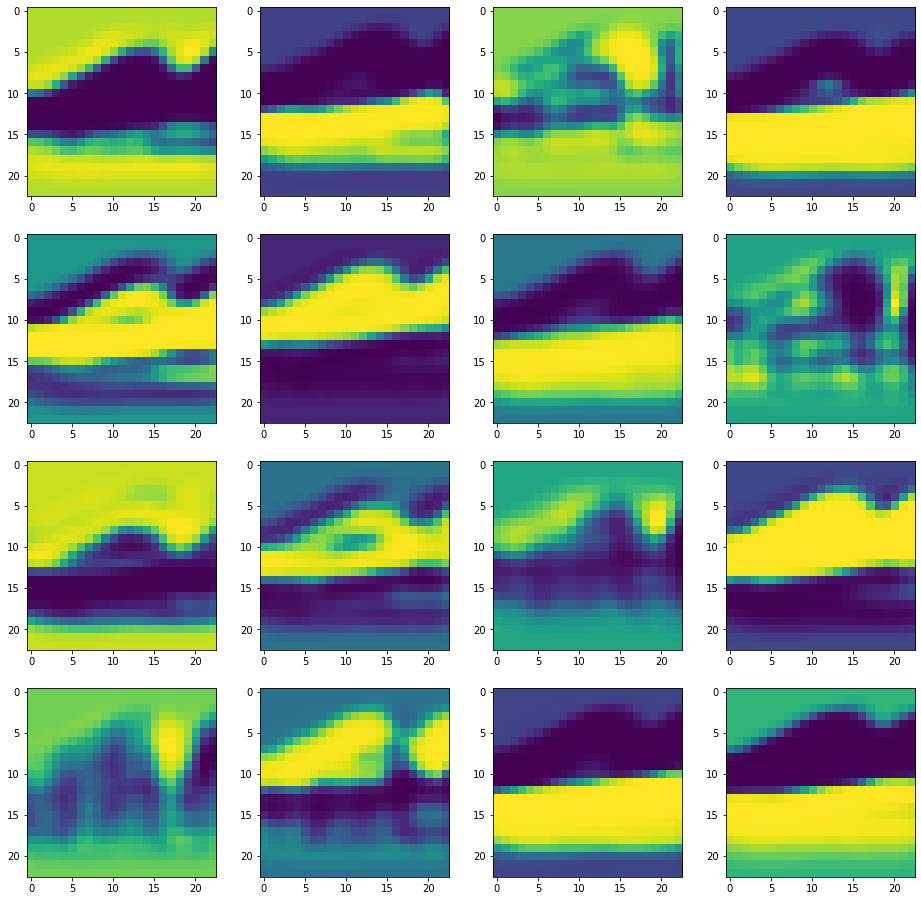

In [0]:
b = model3.predict(x_test[:10])

plt.figure(figsize=(16,16))
for i in range(4):
  for j in range(4):
    plt.subplot(4,4,i*4+j+1)
    plt.imshow(b[9][:,:,i*4+j])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


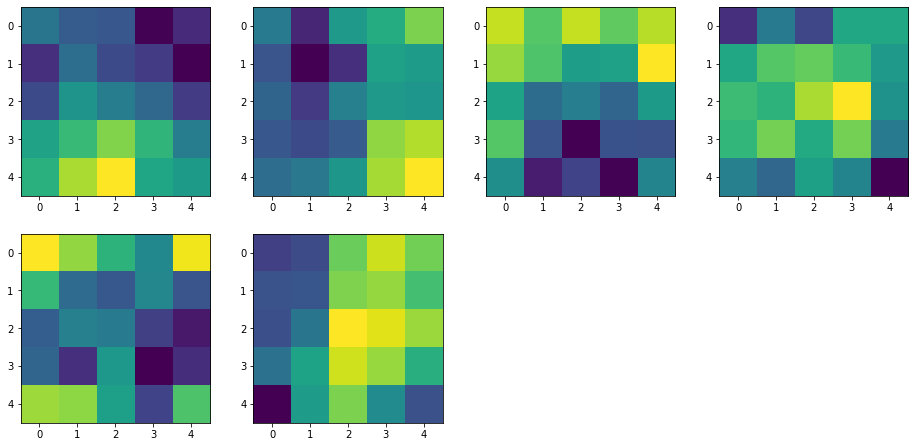

In [0]:
wg1 = model5.get_layer(index = 1)
w_1 = wg1.get_weights()

plt.figure(figsize=(16,16))
for i in range(2):
  for j in range(4):
    plt.subplot(4,4,i*2+j+1)
    plt.imshow(w_1[0][:,:,0,i*2+j])
plt.show()

In [0]:
Как работает реальный пример

##  Домашнее задание

### Ligth 

1. Проверить как идет обучение при различных параметрах модели для выборки "Ирисы Фишера":
    
    - Измените размер batch_size : 1, 10, 20, 50
    
    - измените значение lyambd: 0.01, 0.1, 0.5, 1 
    
    - измените число нейронов в скрытом слое : 1, 5, 50

2. Сделайте несколько перезапусков каждой модели (10 перезапусков с вычислением среднего и дисперсии для оценки точности).

3. Оцените изменения параметров статистик точности при изменении параметров модели. 

### Pro

Соберите свою модель многослойного нелинейного перцептрона (функционально или в форме класс-объект)

1. Возьмите модель1 "Ирисы Фишера" и модель2 данных "MNIST".

2. Проведите обучение для модели1 и модели2 на одинаковых моделях (2 слоя, n -  нейронов) и оцените статистики (среднее и дисперсию оценки точности моделей) 

3. Сделайте выводы о том как вели себя модели в процессе обучени и что влияет на качество обучении.